<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-the-pretrained-Inception-model" data-toc-modified-id="Load-the-pretrained-Inception-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the pretrained Inception model</a></span></li><li><span><a href="#Load-Coco-Animals-Dataset" data-toc-modified-id="Load-Coco-Animals-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Coco Animals Dataset</a></span></li><li><span><a href="#Load-ImageNet-dataset-for-labels" data-toc-modified-id="Load-ImageNet-dataset-for-labels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load ImageNet dataset for labels</a></span></li><li><span><a href="#define-common-imports-and-variables" data-toc-modified-id="define-common-imports-and-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>define common imports and variables</a></span></li><li><span><a href="#Predict-coco-animals-images-using-Inception-V3" data-toc-modified-id="Predict-coco-animals-images-using-Inception-V3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predict coco animals images using Inception V3</a></span></li><li><span><a href="#Predict-coco-animals-images-using-Inception-V3---Preprocessing-in-TF" data-toc-modified-id="Predict-coco-animals-images-using-Inception-V3---Preprocessing-in-TF-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict coco animals images using Inception V3 - Preprocessing in TF</a></span></li><li><span><a href="#Predict-coco-animals-images-using-retrained-Inception-V3" data-toc-modified-id="Predict-coco-animals-images-using-retrained-Inception-V3-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict coco animals images using retrained Inception V3</a></span></li></ul></div>

# Inception V3 in TensorFlow <a class="tocSkip">

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from tensorflow.contrib import slim

NumPy:1.14.5
Matplotlib:2.2.2
TensorFlow:1.11.0


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')
models_root = os.path.join(os.path.expanduser('~'),'models')


# Inception V3 Model in TensorFlow

### Load the pretrained Inception model

In [3]:
# load the inception v3 model
model_name='inception_v3'
model_url='http://download.tensorflow.org/models/'
model_files=['inception_v3_2016_08_28.tar.gz']
model_home=os.path.join(models_root,model_name)        
        
dsu.download_dataset(source_url=model_url,
                        source_files=model_files,
                        dest_dir = model_home,
                        force=False,
                        extract=True)

Already exists: /home/ubuntu/models/inception_v3/inception_v3_2016_08_28.tar.gz


['inception_v3_2016_08_28.tar.gz']

In [4]:
# helper function

def disp(images,id2label=None,probs=None,n_top=5,scale=False):
    if scale:
        imgs = (images / 2.0) + 0.5
    else:
        imgs = images

    ids={}
    for j in range(len(images)):
        if scale:
            plt.figure(figsize=(5,5))
            plt.imshow(imgs[j])
        else:
            plt.imshow(imgs[j].astype(np.uint8) )
        plt.show()
        if probs is not None:
            ids[j] = [i[0] for i in sorted(enumerate(-probs[j]), key=lambda x:x[1])]
            for k in range(n_top):
                id = ids[j][k]
                print('Probability {0:1.2f}% of [{1:}]'
                      .format(100*probs[j,id],id2label[id]))

### Load Coco Animals Dataset

In [5]:
# Load the dataset
from datasetslib.coco import coco_animals

coco = coco_animals()
x_train_files, y_train, x_val_files, x_val = coco.load_data()
x_test = [x_val_files[25*x] for x in range(8)]
images_test=np.array([coco.preprocess_for_inception(x) for x in x_test])

Already exists: /home/ubuntu/datasets/coco-animals/coco-animals.zip


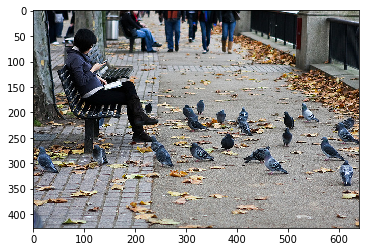

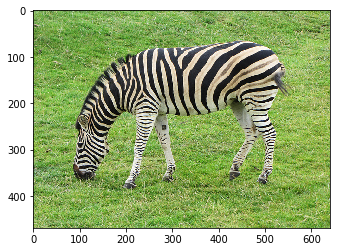

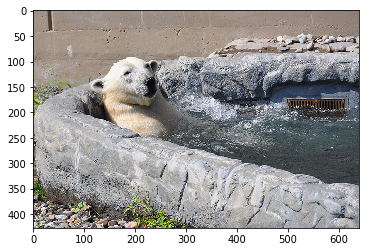

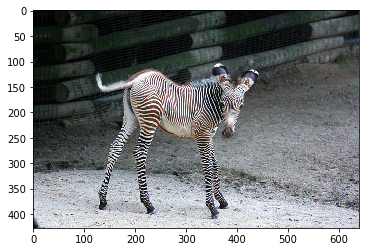

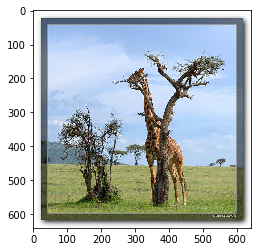

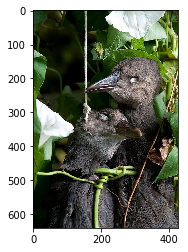

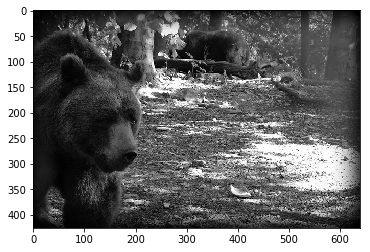

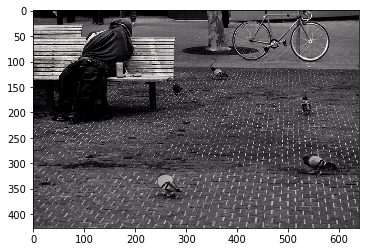

In [6]:
images=np.array([mpimg.imread(x) for x in x_test])

disp(images)

In [7]:
print([x.shape for x in images])

[(427, 640, 3), (469, 640, 3), (427, 640, 3), (427, 640, 3), (640, 640, 3), (640, 426, 3), (426, 640, 3), (427, 640, 3)]


In [8]:
print(images_test.shape)

(8, 299, 299, 3)


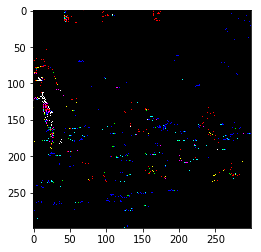

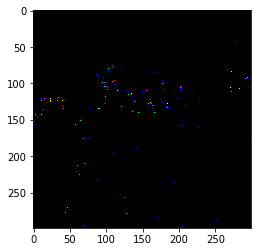

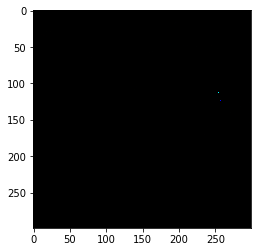

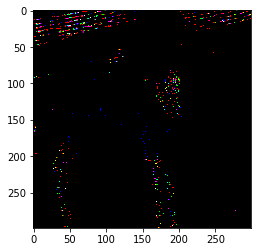

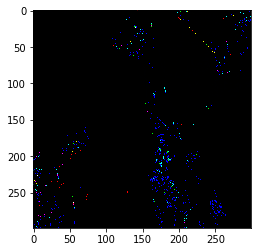

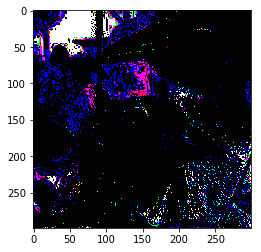

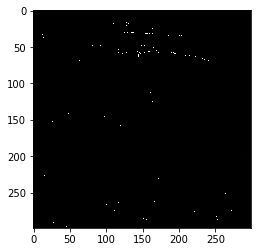

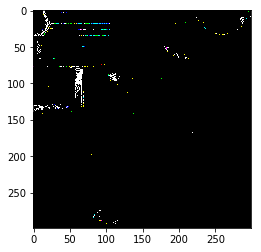

In [9]:
disp(images_test)

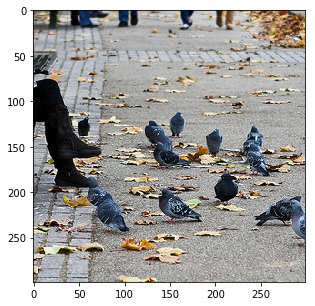

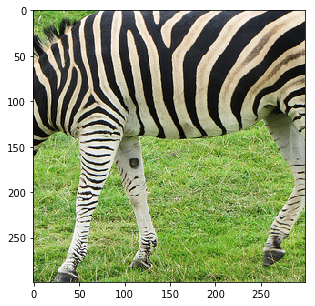

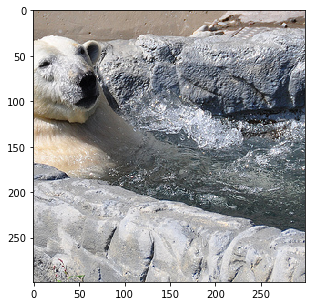

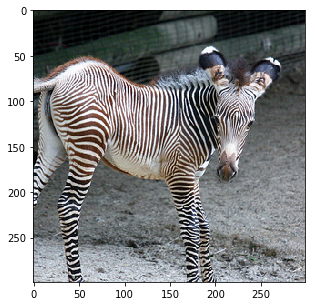

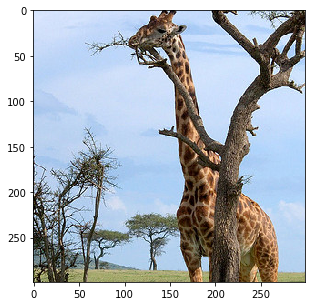

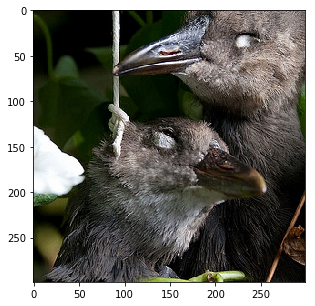

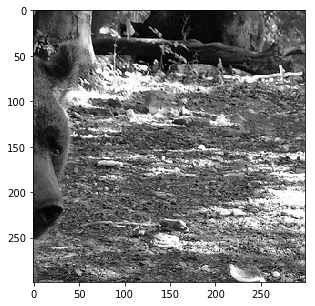

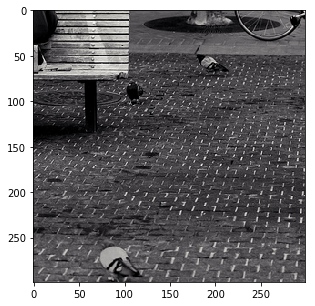

In [10]:
disp(images_test,scale=True)

### Load ImageNet dataset for labels

In [11]:
### Load ImageNet dataset for labels
from datasetslib.imagenet import imageNet
inet = imageNet()
inet.load_data(n_classes=1001)

### define common imports and variables

In [12]:
### define common imports and variables
from tensorflow.contrib.slim.nets import inception
image_height=inception.inception_v3.default_image_size
image_width=inception.inception_v3.default_image_size

### Predict coco animals images using Inception V3

In [13]:
tf.reset_default_graph()

In [14]:
x_p = tf.placeholder(shape=(None,image_height, image_width,3),
                     dtype=tf.float32,
                     name='x_p'
                    )
print(x_p)

Tensor("x_p:0", shape=(?, 299, 299, 3), dtype=float32)


In [15]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits,_ = inception.inception_v3(x_p,
                                      num_classes=inet.n_classes,
                                      is_training=False
                                     )
probabilities = tf.nn.softmax(logits)

init = slim.assign_from_checkpoint_fn(
        os.path.join(model_home, '{}.ckpt'.format(model_name)),
        slim.get_variables_to_restore())

In [16]:
with tf.Session() as tfs:
    init(tfs)
    probs = tfs.run([probabilities],feed_dict={x_p:images_test})
    probs=probs[0]

INFO:tensorflow:Restoring parameters from /home/ubuntu/models/inception_v3/inception_v3.ckpt


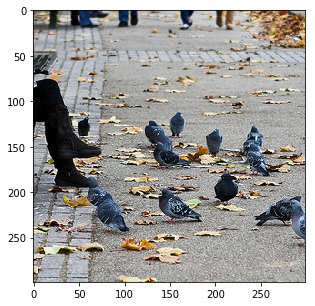

Probability 87.40% of [quail]
Probability 0.80% of [hen]
Probability 0.80% of [jean, blue jean, denim]
Probability 0.57% of [drake]
Probability 0.46% of [cock]


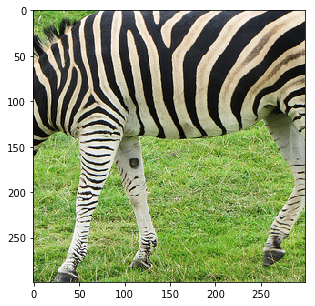

Probability 92.61% of [zebra]
Probability 0.13% of [ostrich, Struthio camelus]
Probability 0.11% of [gondola]
Probability 0.06% of [sock]
Probability 0.06% of [whistle]


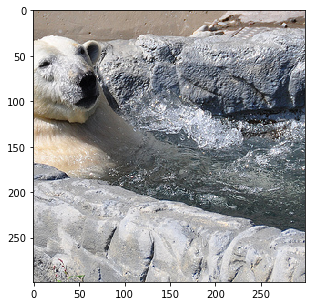

Probability 95.73% of [ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus]
Probability 0.10% of [brown bear, bruin, Ursus arctos]
Probability 0.05% of [American black bear, black bear, Ursus americanus, Euarctos americanus]
Probability 0.03% of [canoe]
Probability 0.03% of [giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca]


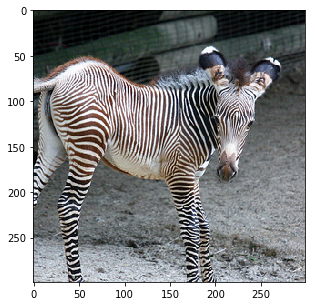

Probability 93.07% of [zebra]
Probability 0.09% of [hartebeest]
Probability 0.08% of [ostrich, Struthio camelus]
Probability 0.06% of [gondola]
Probability 0.03% of [lionfish]


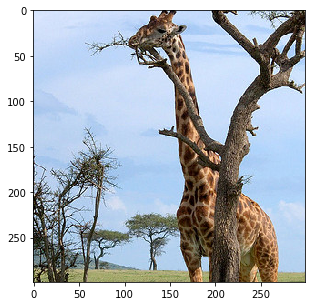

Probability 48.23% of [leopard, Panthera pardus]
Probability 7.83% of [cheetah, chetah, Acinonyx jubatus]
Probability 6.29% of [gazelle]
Probability 2.80% of [lynx, catamount]
Probability 2.03% of [hyena, hyaena]


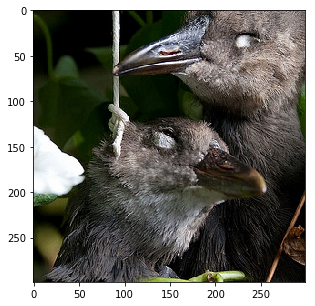

Probability 36.73% of [jay]
Probability 9.67% of [little blue heron, Egretta caerulea]
Probability 3.17% of [water ouzel, dipper]
Probability 2.87% of [European gallinule, Porphyrio porphyrio]
Probability 2.52% of [magpie]


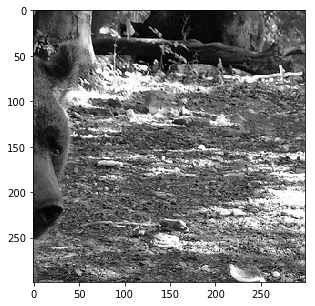

Probability 91.48% of [brown bear, bruin, Ursus arctos]
Probability 1.53% of [American black bear, black bear, Ursus americanus, Euarctos americanus]
Probability 1.40% of [wild boar, boar, Sus scrofa]
Probability 0.52% of [hyena, hyaena]
Probability 0.52% of [wallaby, brush kangaroo]


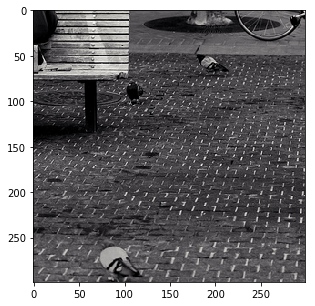

Probability 65.48% of [park bench]
Probability 4.36% of [unicycle, monocycle]
Probability 4.36% of [swing]
Probability 2.70% of [tricycle, trike, velocipede]
Probability 1.23% of [ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin]


In [17]:
disp(images_test,id2label=inet.id2label,probs=probs,scale=True)

### Predict coco animals images using Inception V3 - Preprocessing in TF

In [18]:
tf.reset_default_graph()

In [19]:
def tf_preprocess(filelist):
    images=[]
    for filename in filelist:
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image_float = tf.cast(image_decoded, tf.float32)
        resize_fn = tf.image.resize_image_with_crop_or_pad
        image_resized = resize_fn(image_float, 
                                  image_height, 
                                  image_width
                                 )
        image =  ((image_resized / 255.0) - 0.5) * 2.0
        images.append(image)
        
    images = tf.stack(images)
    return images

In [20]:
images=tf_preprocess([x for x in x_test])
print(images)

Tensor("stack:0", shape=(8, 299, 299, 3), dtype=float32)


In [21]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits,_ = inception.inception_v3(images,
                                      num_classes=inet.n_classes,
                                      is_training=False
                                     )
probabilities = tf.nn.softmax(logits)

init = slim.assign_from_checkpoint_fn(
        os.path.join(model_home, '{}.ckpt'.format(model_name)),
        slim.get_variables_to_restore())

In [22]:
with tf.Session() as tfs:
    init(tfs)
    np_images,probs = tfs.run([images,probabilities])

INFO:tensorflow:Restoring parameters from /home/ubuntu/models/inception_v3/inception_v3.ckpt


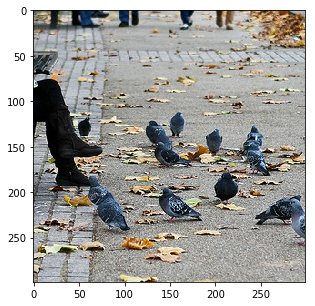

Probability 89.93% of [quail]
Probability 1.17% of [jean, blue jean, denim]
Probability 0.31% of [ruddy turnstone, Arenaria interpres]
Probability 0.25% of [drake]
Probability 0.20% of [lakeside, lakeshore]


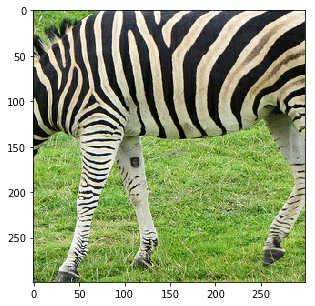

Probability 91.57% of [zebra]
Probability 0.14% of [ostrich, Struthio camelus]
Probability 0.12% of [gondola]
Probability 0.07% of [hartebeest]
Probability 0.07% of [whistle]


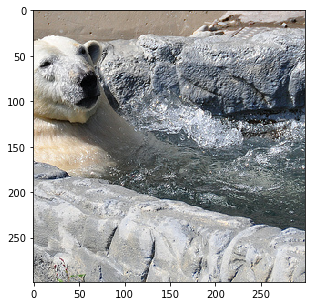

Probability 96.48% of [ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus]
Probability 0.09% of [brown bear, bruin, Ursus arctos]
Probability 0.04% of [American black bear, black bear, Ursus americanus, Euarctos americanus]
Probability 0.03% of [canoe]
Probability 0.02% of [sloth bear, Melursus ursinus, Ursus ursinus]


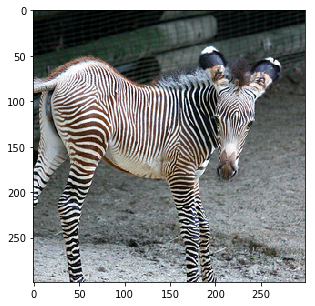

Probability 92.72% of [zebra]
Probability 0.09% of [hartebeest]
Probability 0.08% of [ostrich, Struthio camelus]
Probability 0.07% of [gondola]
Probability 0.03% of [Tibetan terrier, chrysanthemum dog]


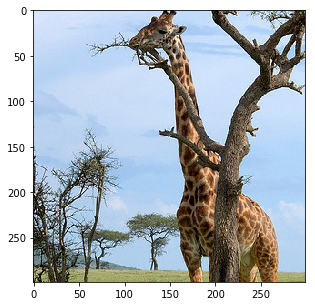

Probability 47.37% of [leopard, Panthera pardus]
Probability 7.66% of [cheetah, chetah, Acinonyx jubatus]
Probability 5.06% of [gazelle]
Probability 3.32% of [lynx, catamount]
Probability 3.23% of [hyena, hyaena]


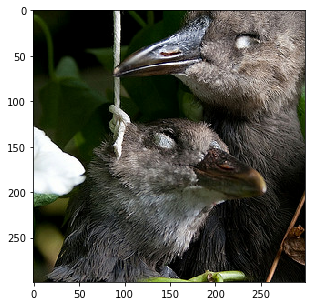

Probability 41.52% of [jay]
Probability 8.33% of [little blue heron, Egretta caerulea]
Probability 3.21% of [magpie]
Probability 2.52% of [ostrich, Struthio camelus]
Probability 2.32% of [bustard]


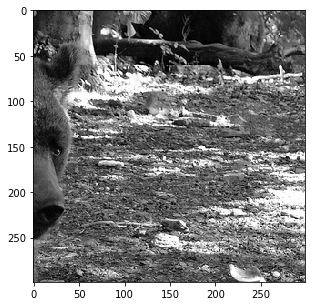

Probability 90.05% of [brown bear, bruin, Ursus arctos]
Probability 3.23% of [wild boar, boar, Sus scrofa]
Probability 1.20% of [American black bear, black bear, Ursus americanus, Euarctos americanus]
Probability 0.74% of [hyena, hyaena]
Probability 0.48% of [hog, pig, grunter, squealer, Sus scrofa]


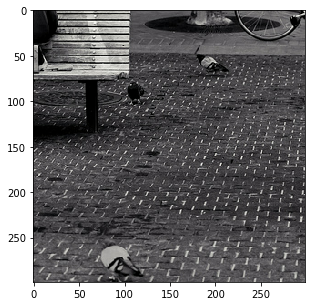

Probability 65.05% of [park bench]
Probability 4.52% of [unicycle, monocycle]
Probability 2.63% of [tricycle, trike, velocipede]
Probability 1.87% of [ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin]
Probability 1.58% of [swing]


In [23]:
disp(np_images,id2label=inet.id2label,probs=probs,scale=True)